In [14]:
import pandas as pd
import numpy as np
import os
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

gc.collect()

4632

In [ ]:
if not os.path.exists("sp500.csv"):
    raise FileNotFoundError("sp500.csv not found. Make sure the file is in the directory.")

sp500 = pd.read_csv("sp500.csv")
sp500['Date'] = pd.to_datetime(sp500['Date'], errors='coerce', utc=True)
sp500.set_index("Date", inplace=True)

sp500.drop(columns=[col for col in ["Dividends", "Stock Splits"] if col in sp500.columns], inplace=True)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

sp500["SMA_10"] = sp500["Close"].rolling(window=10).mean()
sp500["SMA_50"] = sp500["Close"].rolling(window=50).mean()
sp500["RSI_14"] = 100 - (100 / (1 + sp500["Close"].diff().apply(lambda x: max(x, 0)).rolling(window=14).mean() / sp500["Close"].diff().apply(lambda x: abs(x)).rolling(window=14).mean()))
exp1 = sp500["Close"].ewm(span=12, adjust=False).mean()
exp2 = sp500["Close"].ewm(span=26, adjust=False).mean()
sp500["MACD"] = exp1 - exp2
sp500["EMA_20"] = sp500["Close"].ewm(span=20, adjust=False).mean()
sp500["EMA_50"] = sp500["Close"].ewm(span=50, adjust=False).mean()
sp500["Bollinger_Upper"] = sp500["Close"].rolling(20).mean() + 2 * sp500["Close"].rolling(20).std()
sp500["Bollinger_Lower"] = sp500["Close"].rolling(20).mean() - 2 * sp500["Close"].rolling(20).std()


sp500.dropna(inplace=True)

sp500.index = pd.to_datetime(sp500.index, errors='coerce', utc=True).tz_localize(None)
sp500 = sp500.loc[pd.Timestamp("1990-01-01"):].copy()


data = sp500.values 


time_steps = 10


num_samples = data.shape[0] // time_steps  
num_features = data.shape[1]  

X = data[:num_samples * time_steps].reshape(num_samples, time_steps, num_features)


train_df = sp500[sp500.index.year < 2024].copy()
test_df = sp500[sp500.index.year >= 2024].copy()

print("Training period: {} to {}".format(train_df.index.min().date(), train_df.index.max().date()))
print("Testing period: {} to {}".format(test_df.index.min().date(), test_df.index.max().date()))

Training period: 1990-01-02 to 2023-12-29
Testing period: 2024-01-02 to 2025-02-27


In [ ]:
predictors = ["Close", "Volume", "Open", "High", "Low", "SMA_10", "SMA_50", "RSI_14", "MACD", "EMA_20", "EMA_50", "Bollinger_Upper", "Bollinger_Lower"]
from xgboost import XGBClassifier
rf_model = RandomForestClassifier(n_estimators=300, min_samples_split=20, max_depth=10, random_state=1)
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=10, eval_metric='logloss')
xgb_model.fit(train_df[predictors], train_df["Target"])


def predict(test, model, predictors):
    preds = model.predict_proba(test[predictors])[:, 1]
    preds = (preds >= 0.6).astype(int)
    preds = pd.Series(preds, index=test.index, name="Predictions")
    return pd.concat([test["Target"], preds], axis=1)

def backtest(data, model, predictors, start=1000, step=250):
    import time
    all_predictions = []
    total_steps = (data.shape[0] - start) // step
    for i, progress in enumerate(range(start, data.shape[0], step), 1):
        print(f"Processing step {i}/{total_steps}...")
        start_time = time.time()
        train = data.iloc[:progress].copy()  
        test = data.iloc[progress:progress + step].copy()
        if 'Target' not in test.columns:
            test['Target'] = data['Target'].iloc[progress:progress + step]  
        model.fit(train[predictors], train['Target'])  
        predictions = predict(test, model, predictors)
        all_predictions.append(predictions)
        print(f"Step {i}/{total_steps} completed in {time.time() - start_time:.2f} seconds.")
    return pd.concat(all_predictions)
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

rf_predictions = backtest(sp500, rf_model, predictors)
print("Random Forest Precision Score:", precision_score(rf_predictions["Target"], rf_predictions["Predictions"]))

Processing step 1/31...
Step 1/31 completed in 0.78 seconds.
Processing step 2/31...
Step 2/31 completed in 0.82 seconds.
Processing step 3/31...
Step 3/31 completed in 0.98 seconds.
Processing step 4/31...
Step 4/31 completed in 1.09 seconds.
Processing step 5/31...
Step 5/31 completed in 1.21 seconds.
Processing step 6/31...
Step 6/31 completed in 1.33 seconds.
Processing step 7/31...
Step 7/31 completed in 1.44 seconds.
Processing step 8/31...
Step 8/31 completed in 1.63 seconds.
Processing step 9/31...
Step 9/31 completed in 1.72 seconds.
Processing step 10/31...
Step 10/31 completed in 1.83 seconds.
Processing step 11/31...
Step 11/31 completed in 1.97 seconds.
Processing step 12/31...
Step 12/31 completed in 2.25 seconds.
Processing step 13/31...
Step 13/31 completed in 2.25 seconds.
Processing step 14/31...
Step 14/31 completed in 2.45 seconds.
Processing step 15/31...
Step 15/31 completed in 2.57 seconds.
Processing step 16/31...
Step 16/31 completed in 2.78 seconds.
Processing

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500.dropna(inplace=True)


train_df = sp500[sp500.index.year < 2024].copy()
test_df = sp500[sp500.index.year >= 2024].copy()


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[predictors])
test_scaled = scaler.transform(test_df[predictors])


target_scaler = MinMaxScaler()
y_train = train_df["Tomorrow"].values.reshape(-1, 1)
y_train_scaled = target_scaler.fit_transform(y_train)
y_test = test_df["Tomorrow"].values.reshape(-1, 1)
y_test_scaled = target_scaler.transform(y_test)

def create_sequences(data, target, window):
    X, y = [], []
    for i in range(len(data) - window - 1):
        X.append(data[i:i+window])
        y.append(target[i + window])  
    return np.array(X), np.array(y)

window = 60
X_train, y_train = create_sequences(train_scaled, y_train_scaled.flatten(), window)
X_test, y_test = create_sequences(test_scaled, y_test_scaled.flatten(), window)
X_train = X_train.reshape(X_train.shape[0], window, len(predictors))
X_test = X_test.reshape(X_test.shape[0], window, len(predictors))


lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window, len(predictors))),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1)  
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
y_pred_scaled = lstm_model.predict(X_test)

Epoch 1/100


c:\Users\AhmedBafuleh\Documents\GitHub\ai-ml-with-python-and-knime-2024\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0091
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0014
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0013
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0014
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 9.8849e-04
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 9.3605e-04
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 9.4281e-04
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 7.6608e-04
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 7.6171e-04
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 7.8295e-04
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 7.2112e-04
Epoch 12/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 6.8414e-04
Epoch 13/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 7.0485e-04
Epoch 14/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 6.8843e-04
E

Ensemble Precision: 0.6666666666666666


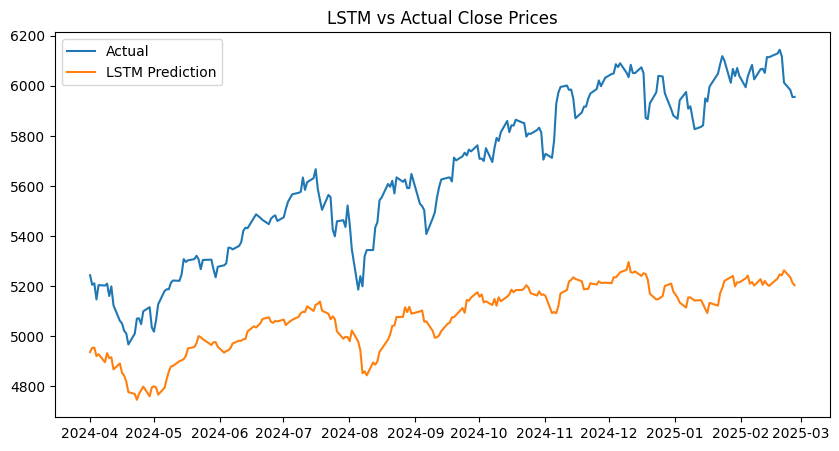

In [ ]:
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()


actual_closes = test_df["Close"].values[window:-1]  
lstm_binary = (y_pred > actual_closes).astype(int)


rf_proba = rf_model.predict_proba(test_df[predictors])[:, 1]
xgb_proba = xgb_model.predict_proba(test_df[predictors])[:, 1]


min_len = min(len(rf_proba), len(xgb_proba), len(lstm_binary))
rf_proba = rf_proba[-min_len:]
xgb_proba = xgb_proba[-min_len:]
lstm_binary = lstm_binary[-min_len:]

ensemble_predictions = (
    0.4 * rf_proba + 
    0.4 * xgb_proba + 
    0.2 * lstm_binary  
) >= 0.5


aligned_target = test_df["Target"].iloc[window + 1 : window + 1 + min_len]
pred_dates = test_df.index[window + 1 : window + 1 + min_len]


print("Ensemble Precision:", precision_score(aligned_target, ensemble_predictions))


plt.figure(figsize=(10,5))
plt.plot(pred_dates, test_df.loc[pred_dates, "Close"], label="Actual")
plt.plot(pred_dates, y_pred[-min_len:], label="LSTM Prediction")
plt.legend()
plt.title("LSTM vs Actual Close Prices")
plt.show()